In [1]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from ephysvibe.stats import smetrics
import matplotlib.pyplot as plt

In [3]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [4]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [5]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [7]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

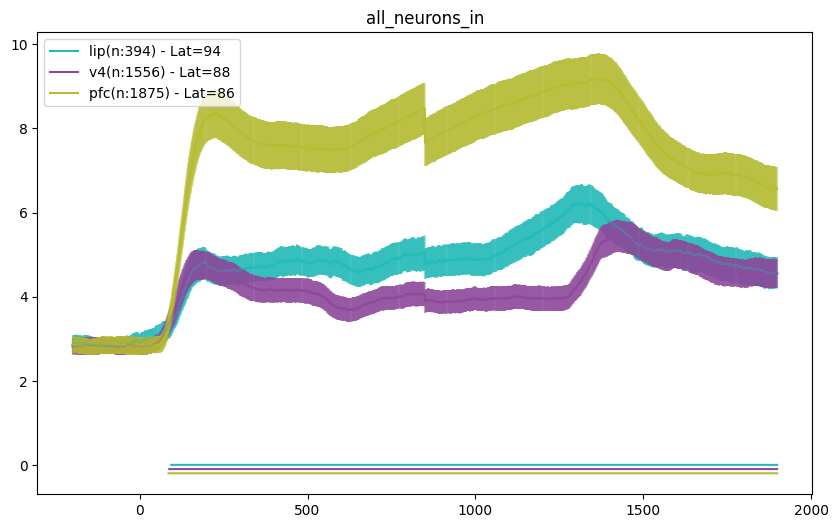

In [29]:
res1 = {}
for area in ['lip','v4','pfc']:#'lip',
    res1[area]=from_python_hdf5('//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/all_neurons_in/2024-08-21_16-50-55/'+area+'_population_dist.h5')[0]
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','v4','pfc']):
    d=res1[area]['dist_n_nn'][:,:]
    fd=res1[area]['dist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_in')

In [ ]:
res1 = {}
for area in ['lip','v4','pfc']:#'lip',
    res1[area]=from_python_hdf5('//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/all_neurons_out/2024-08-21_16-50-55/'+area+'_population_dist.h5')[0]
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','v4','pfc']):
    d=res1[area]['dist_n_nn'][:,:]
    fd=res1[area]['dist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_out')

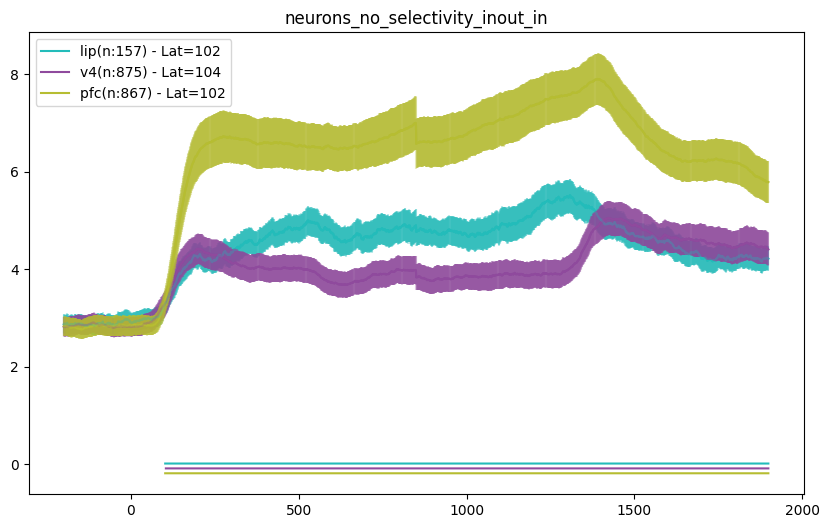

In [12]:
res1 = {}
for area in ['lip','v4','pfc']:#'lip',
    res1[area]=from_python_hdf5('//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/neurons_no_selectivity_inout_in/2024-08-22_10-02-48/'+area+'_population_dist.h5')[0]
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','v4','pfc']):
    d=res1[area]['dist_n_nn'][:,:]
    fd=res1[area]['dist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('neurons_no_selectivity_inout_in')

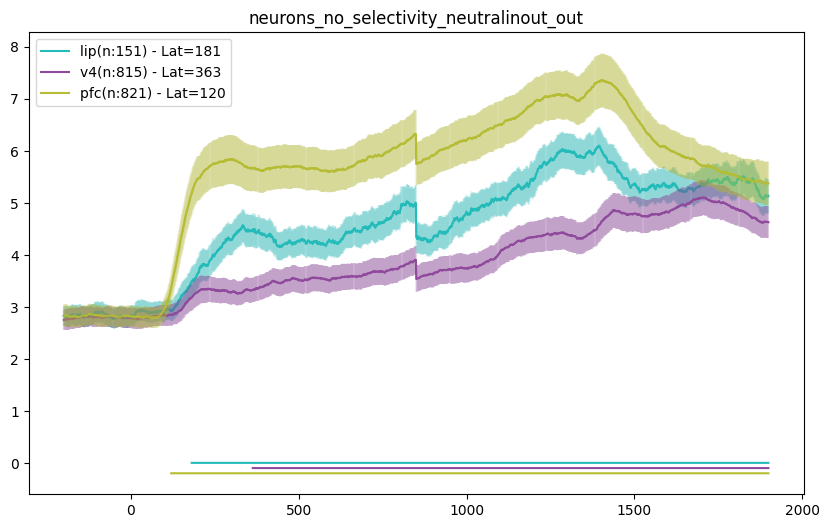

In [15]:
res1 = {}
for area in ['lip','v4','pfc']:#'lip',
    res1[area]=from_python_hdf5('//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/neurons_no_selectivity_inout_out/2024-08-22_11-00-30/'+area+'_population_dist.h5')[0]
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','v4','pfc']):
    d=res1[area]['dist_n_nn'][:,:]
    fd=res1[area]['dist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.1)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('neurons_no_selectivity_neutralinout_out')